# Code Example - Turnout Model for Alamance County, NC
Author: Lucy Ding

## 1 - Load and Clean Data

In [186]:
# Set up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

In [187]:
# Load data - vote history and voter file
data_vh = pd.read_csv('~/github_repos/code_sample/ncvhis1.txt', sep = '\t')
data_vf = pd.read_csv('~/github_repos/code_sample/ncvoter1.txt', sep = '\t', encoding='unicode_escape')

### 1.1 - Vote History Data

In [188]:
# Clean election description
data_vh[['election_date', 'election_type']] = data_vh['election_desc'].str.split(" ", n=1, expand=True)

data_vh['election_date'] = pd.to_datetime(data_vh['election_date'])
data_vh['election_year'] = data_vh['election_date'].dt.year

data_vh['election_type'] = np.select(
    [
        data_vh['election_type'].isin(['GENERAL']),
        data_vh['election_type'].isin(['PRIMARY', 'CONGRESSIONAL PRIMARY']),
    ],
    ['vote_g_', 'vote_p_'],
    default = 'vote_o_'
)

data_vh['election_desc'] = data_vh['election_type'] + data_vh['election_year'].astype(str)
data_vh['vote_cast'] = 1

In [189]:
# Set up vote history data
data_vh_vote = data_vh.pivot_table(index = 'voter_reg_num', 
                                   columns = 'election_desc', 
                                   values = 'vote_cast', 
                                   aggfunc = 'max')
data_vh_vote = data_vh_vote.reset_index()

# Replace null votes with 0
data_vh_vote = data_vh_vote.fillna(0)

data_vh_vote.head()

election_desc,voter_reg_num,vote_g_2015,vote_g_2016,vote_g_2017,vote_g_2018,vote_g_2019,vote_g_2020,vote_g_2022,vote_g_2024,vote_o_2015,...,vote_o_2022,vote_o_2023,vote_o_2024,vote_p_2016,vote_p_2018,vote_p_2019,vote_p_2020,vote_p_2022,vote_p_2023,vote_p_2024
0,4100,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
1,4700,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
2,6900,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
3,8800,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9000,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### 1.2 - Voter File Data

In [190]:
# Check for dupes in voterfile
data_vf[data_vf.duplicated(['voter_reg_num'])]

,county_id,county_desc,voter_reg_num,ncid,last_name,first_name,middle_name,name_suffix_lbl,status_cd,voter_status_desc,...,sanit_dist_abbrv,sanit_dist_desc,rescue_dist_abbrv,rescue_dist_desc,munic_dist_abbrv,munic_dist_desc,dist_1_abbrv,dist_1_desc,vtd_abbrv,vtd_desc


In [191]:
# View voter file status combinations
data_vf.groupby(['status_cd', 'voter_status_desc', 'reason_cd', 'voter_status_reason_desc']).size().reset_index(name='count')

,status_cd,voter_status_desc,reason_cd,voter_status_reason_desc,count
0,A,ACTIVE,A1,UNVERIFIED,7
1,A,ACTIVE,A2,CONFIRMATION PENDING,467
2,A,ACTIVE,AN,UNVERIFIED NEW,18
3,A,ACTIVE,AP,VERIFICATION PENDING,720
4,A,ACTIVE,AV,VERIFIED,108264
5,A,ACTIVE,IN,CONFIRMATION NOT RETURNED,20
6,A,ACTIVE,IU,CONFIRMATION RETURNED UNDELIVERABLE,20
7,D,DENIED,DI,UNAVAILABLE ESSENTIAL INFORMATION,342
8,D,DENIED,DU,VERIFICATION RETURNED UNDELIVERABLE,2300
9,D,DENIED,RS,MOVED FROM STATE,1


In [192]:
# Clean voter file status
data_vf['voter_status'] = np.select(
    [
        data_vf['reason_cd'] == 'AV',
        data_vf['reason_cd'].isin(['RS', 'RD', 'RF'])
    ],
    ['A','R'],
    default = 'I'
)

# Set up birth state out of state
data_vf['birth_state_oos'] = (data_vf['birth_state'] != 'NC').astype(int)

# Code drivers license
data_vf['drivers_lic'] = (data_vf['drivers_lic'] == 'Y').astype(int)

# Pull registration year
data_vf['reg_year'] = pd.to_datetime(data_vf['registr_dt'], errors = 'coerce').dt.year

In [193]:
# Select columns
data_vf = data_vf[['voter_reg_num', 'voter_status', 'reg_year', 'race_code', 
                   'ethnic_code', 'gender_code', 'birth_year', 'birth_state_oos', 
                   'drivers_lic']]

# OHE vote status, race, ethnicity, gender
ohe_cols = ['voter_status', 'race_code', 'ethnic_code', 'gender_code']
ohe = OneHotEncoder(sparse = False)
data_ohe = ohe.fit_transform(data_vf[ohe_cols])
data_ohe = pd.DataFrame(data_ohe, columns=ohe.get_feature_names(ohe_cols))
data_vf = pd.concat([data_vf, data_ohe], axis=1)
data_vf = data_vf.drop(ohe_cols, axis=1)

data_vf.head()

,voter_reg_num,reg_year,birth_year,birth_state_oos,drivers_lic,voter_status_A,voter_status_I,voter_status_R,race_code_A,race_code_B,...,race_code_O,race_code_P,race_code_U,race_code_W,ethnic_code_HL,ethnic_code_NL,ethnic_code_UN,gender_code_F,gender_code_M,gender_code_U
0,9005990,1984.0,1935,1,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,9178574,2018.0,1978,1,1,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,9205561,2020.0,1966,1,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,9048723,1996.0,1976,0,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,9019674,1989.0,1945,1,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


## 2 - Data Pre-Processing

### 2.1 - Historical Modeling Frame (pre-2020)

In [194]:
# Merge voterfile and vote history data (pre-2020)
hist_mf = pd.merge(data_vf, 
                   data_vh_vote,
                   on = 'voter_reg_num', 
                   how = 'left')

# Handle people with no vote history
hist_mf = hist_mf.fillna(0)

# Change vote history names to be relative to 2020
hist_mf.columns = hist_mf.columns.str.replace(r'2016', '4', regex=True)
hist_mf.columns = hist_mf.columns.str.replace(r'2018', '2', regex=True)
hist_mf.columns = hist_mf.columns.str.replace(r'2020', '0', regex=True)

# Remove columns after 2020
hist_mf = hist_mf.loc[:, ~hist_mf.columns.str.contains(r'2021|2022|2023|2024|2015|2017|2019', regex=True)]

In [195]:
# Create age and years since registration (ref 2020)
hist_mf['age'] = 2020 - hist_mf['birth_year']
hist_mf['years_since_reg'] = 2020 - hist_mf['reg_year']

# Filter out people that registered after 2020
hist_mf = hist_mf[hist_mf['years_since_reg'] > 0]

hist_mf = hist_mf.drop(['birth_year', 'reg_year'], axis=1)

### 2.2 - Current Modeling Frame (pre-2024)

In [196]:
# Merge voterfile and vote history data (pre-2024)
mf = pd.merge(data_vf, 
                   data_vh_vote,
                   on = 'voter_reg_num', 
                   how = 'left')

# Handle people with no vote history
mf = mf.fillna(0)

# Change vote history names to be relative to 2024
mf.columns = mf.columns.str.replace(r'2020', '4', regex=True)
mf.columns = mf.columns.str.replace(r'2022', '2', regex=True)
mf.columns = mf.columns.str.replace(r'2024', '0', regex=True)

# Remove columns with vote years that won't be used
mf = mf.loc[:, ~mf.columns.str.contains(r'2015|2016|2017|2018|2019|2021|2023', regex=True)]

In [197]:
# Create age and years since registration (ref 2024)
mf['age'] = 2024 - mf['birth_year']
mf['years_since_reg'] = 2024 - mf['reg_year']

# Filter out people that registered after 2024
mf = mf[mf['years_since_reg'] > 0]

mf = mf.drop(['birth_year', 'reg_year'], axis=1)

## 3 - Data Modeling

In [198]:
X = hist_mf.drop(['voter_reg_num', 'vote_g_0'], axis=1)
y = hist_mf['vote_g_0']

# Split train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2024)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [200]:
# Train model
model = LogisticRegressionCV(cv = 5, penalty = 'l1', solver = 'saga', max_iter = 5000)
model.fit(X_train_scaled, y_train)

LogisticRegressionCV(cv=5, max_iter=5000, penalty='l1', solver='saga')

Accuracy: 0.8999
ROC AUC: 0.9333


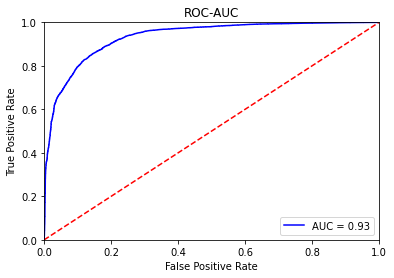

In [201]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Plot ROC-AUC
plt.title('ROC-AUC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [209]:
# Pull LASSO coefs
lasso_coefs = pd.DataFrame({
    'feature': X.columns,
    'coefs': model.coef_[0]
})

In [203]:
# Re-fit on full data
X_scaled = scaler.transform(X)
final_coefs = lasso_coefs[lasso_coefs['coefs'] != 0]['feature'].tolist()
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_lasso = X[final_coefs]

final_model = LogisticRegression(C = model.C_[0], penalty = 'l1', solver = 'saga', max_iter = 5000)
final_model.fit(X_lasso, y)

LogisticRegression(C=0.3593813663804626, max_iter=5000, penalty='l1',
                   solver='saga')

## 4 - Score File for 2020

In [205]:
# Score 2020 voterfile
final_scores = final_model.predict_proba(mf[final_coefs])[:, 1]
mf["turnout_score"] = final_scores

## 5 - Analysis

In [212]:
# Model coefficients
final_coefs = pd.DataFrame({
    'feature': X_lasso.columns,
    'coefs': final_model.coef_[0]
})

In [214]:
# Sort coefficients
final_coefs.iloc[final_coefs['coefs'].abs().argsort()[::-1]]

,feature,coefs
0,voter_status_A,1.976431
23,voter_status_I,-1.634265
2,vote_g_2,1.312980
1,vote_p_0,1.243621
13,voter_status_R,-0.757678
3,vote_g_4,0.525689
21,gender_code_M,-0.268422
12,vote_p_2,0.227395
14,ethnic_code_NL,-0.208046
19,birth_state_oos,-0.166800


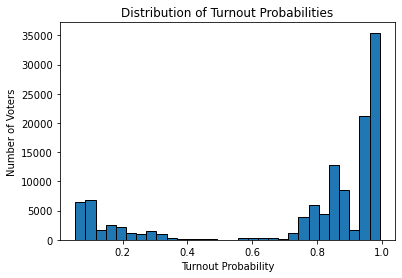

In [211]:
# Plot histogram of turnout scores
plt.hist(mf["turnout_score"], bins=30, edgecolor='black')  # bins=30 sets the number of bins
plt.title('Distribution of Turnout Probabilities')
plt.xlabel('Turnout Probability')
plt.ylabel('Number of Voters')
plt.show()

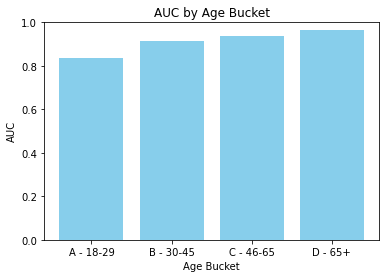

In [215]:
# Plot AUC by age bucket
def age_bucket(age):
    if age < 30:
        return 'A - 18-29'
    elif 30 <= age < 46:
        return 'B - 30-45'
    elif 46 <= age < 65:
        return 'C - 46-65'
    else:
        return 'D - 65+'

# Apply the function to create a new sorted column for age bucket
mf['age_bucket'] = mf['age'].apply(age_bucket)
mf = mf.sort_values(by='age_bucket', ascending=True)

# Calculate AUC by group
auc_by_group = {}
for group in mf['age_bucket'].unique():
    group_data = mf[mf['age_bucket'] == group]
    auc = roc_auc_score(group_data['vote_g_0'], group_data['turnout_score'])
    auc_by_group[group] = auc
auc_df = pd.DataFrame(list(auc_by_group.items()), columns=['age_bucket', 'AUC'])

# Plot AUC by group
plt.bar(auc_df['age_bucket'], auc_df['AUC'], color='skyblue')
plt.xlabel('Age Bucket')
plt.ylabel('AUC')
plt.title('AUC by Age Bucket')
plt.ylim(0, 1)
plt.show()

In [217]:
# Crosstab turnout rate prediction by age bucket
mf.groupby('age_bucket')['turnout_score'].mean().reset_index()

,age_bucket,turnout_score
0,A - 18-29,0.686102
1,B - 30-45,0.720238
2,C - 46-65,0.816685
3,D - 65+,0.762489
